The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services.

Data files are available for the nation, all 50 states, the District of Columbia, Puerto Rico, every congressional district, every metropolitan area, and **all counties and places with populations of 65,000 or more**.

The 5-year estimates from the ACS are "period" estimates that represent data collected over a period of time. The primary advantage of using multiyear estimates is the increased statistical reliability of the data for less populated areas and small population subgroups. 

Data files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, all tracts and block groups. Unlike the 1-year estimates, geographies do not have to meet a particular population threshold in order to be published.

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests, json
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from urllib.parse import quote

In [ ]:
#def get_census_data(variables = [], state = "", county = "*"):
#    census_url = "http://api.census.gov/data/2014/acs5?for=tract:*&in=state:{}+county:{}&get=NAME,{}"
#    addr = census_url.format(state, county, ",".join(variables))
#    return requests.get(addr).json()
#    
#    census_resp = get_census_data(state = 17, county = 31, variables = variables)

In [81]:
addr = "https://api.census.gov/data/2016/acs/acs1/profile?get=DP03_0096PE,NAME&for=state:*"
j = requests.get(addr).json()
with open("data/state_insurance_2016.csv", "w") as out:
    for obs in j:
        stateFIPS = obs[0]
        state = obs[1]
        insurance_coverage = obs[2]
        out.write(",".join([insurance_coverage, state, stateFIPS]) + "\n")

In [82]:
insurance_df = pd.read_csv("data/insurance_coverage.csv", index_col = "state")
insurance_df.rename(columns = {"NAME" : "State", "DP03_0096PE" : "Health Insurance Coverage"}, inplace = True)
insurance_df.head()

,State,Health Insurance Coverage
state,,
1,Alabama,90.9
2,Alaska,86.0
4,Arizona,90.0
5,Arkansas,92.1
6,California,92.7


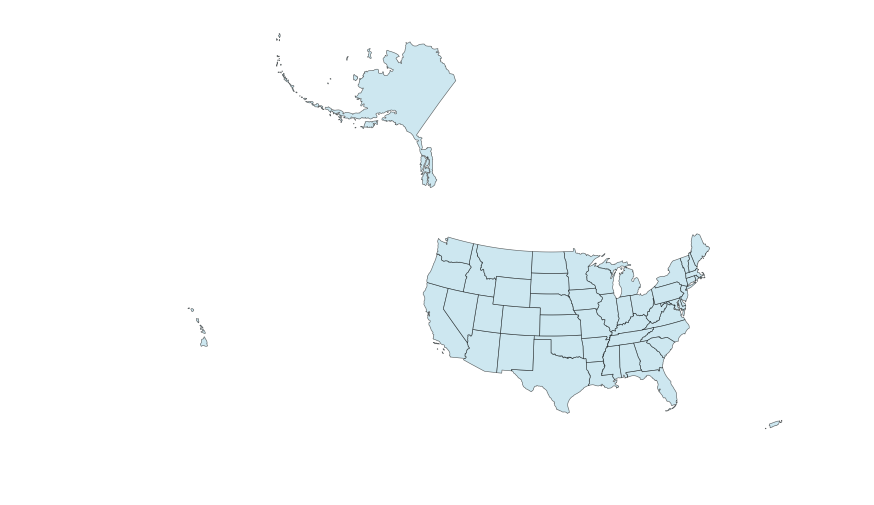

In [83]:
geo_df = gpd.read_file("data/cb_2016_us_state_20m/cb_2016_us_state_20m.shp")
geo_df.set_index(geo_df["STATEFP"].astype(int), inplace = True)
geo_df.to_crs(epsg = 2163).plot(facecolor = "lightblue", alpha = 0.6, edgecolor = "black").set_axis_off()

In [84]:
geo_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
STATEFP,,,,,,,,,,
23,23,01779787,0400000US23,23,ME,Maine,00,79885221885,11748755195,"(POLYGON ((-68.92401 43.885407, -68.8747839999..."
15,15,01779782,0400000US15,15,HI,Hawaii,00,16634100855,11777698394,"(POLYGON ((-156.049651 19.780452, -156.006267 ..."
4,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
5,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698,"POLYGON ((-94.617919 36.499414, -94.3612029999..."
10,10,01779781,0400000US10,10,DE,Delaware,00,5047194742,1398720828,"POLYGON ((-75.773786 39.7222, -75.753227999999..."


In [85]:
geo_merge = geo_df.join(insurance_df, how = "inner")
geo_merge.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,State,Health Insurance Coverage
23,23,01779787,0400000US23,23,ME,Maine,00,79885221885,11748755195,"(POLYGON ((-68.92401 43.885407, -68.8747839999...",Maine,92.0
15,15,01779782,0400000US15,15,HI,Hawaii,00,16634100855,11777698394,"(POLYGON ((-156.049651 19.780452, -156.006267 ...",Hawaii,96.5
4,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.799683 32.593621, -114.809393 3...",Arizona,90.0
5,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698,"POLYGON ((-94.617919 36.499414, -94.3612029999...",Arkansas,92.1
10,10,01779781,0400000US10,10,DE,Delaware,00,5047194742,1398720828,"POLYGON ((-75.773786 39.7222, -75.753227999999...",Delaware,94.3


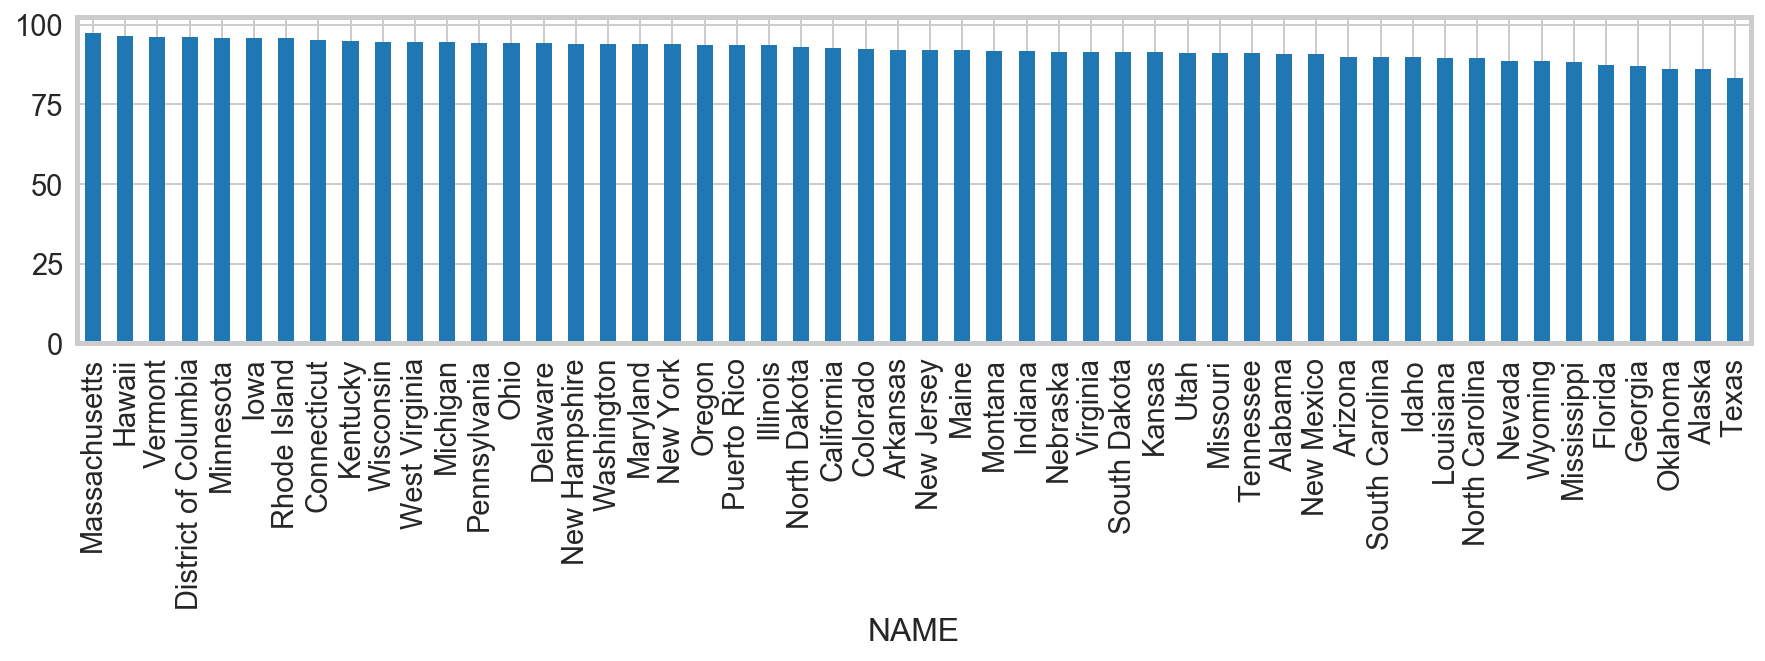

In [86]:
geo_merge.set_index("NAME")["Health Insurance Coverage"]\
         .sort_values(ascending = False)\
         .plot(kind = "bar", figsize = (15, 3))

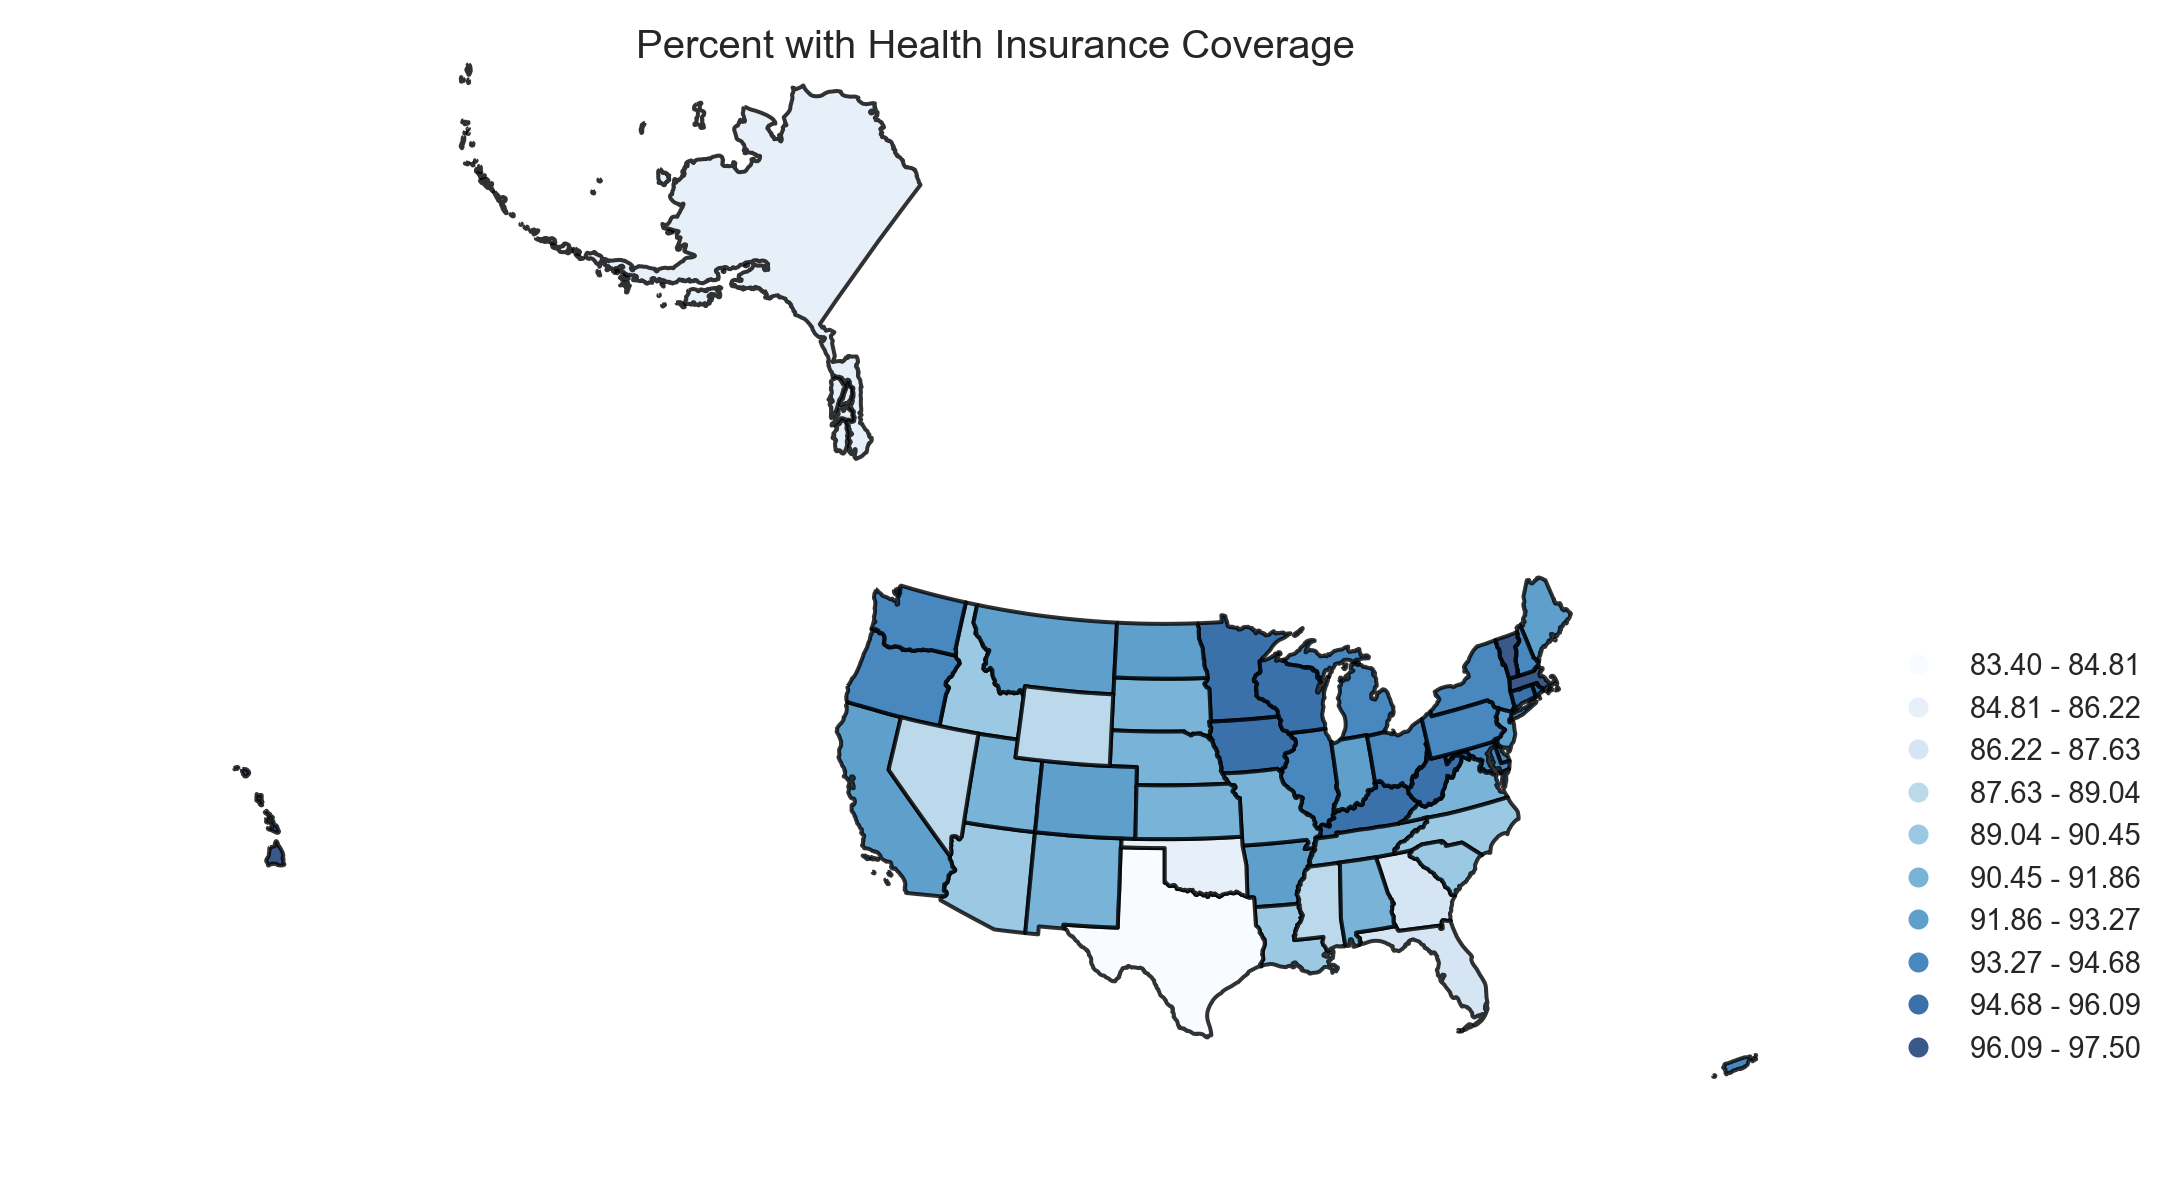

In [87]:
albers = geo_merge.to_crs(epsg=2163)
ax = albers.plot(column = "Health Insurance Coverage", cmap = "Blues", scheme = "equal_interval", k = 10, 
                 legend = True, alpha = 0.8, linewidth = 2, edgecolor = "black", figsize = (15, 15))

ax.set_title("Percent with Health Insurance Coverage", fontsize = 20, y = 0.95)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((1.2, 0.45))
ax.get_legend().get_frame().set_linewidth(0)

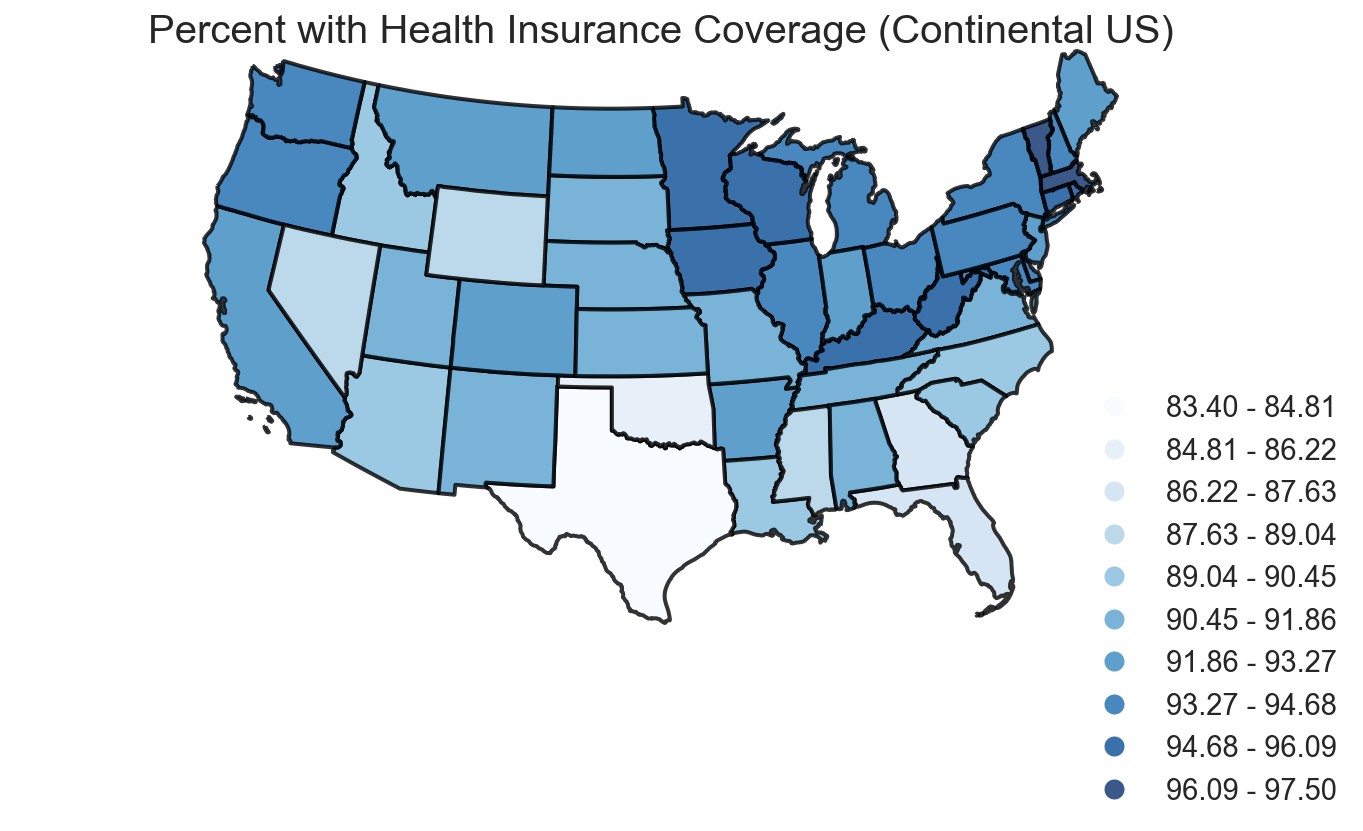

In [88]:
# Excluding Alaska, Hawaii, and the territories:
contiguous =  (geo_df.index < 57)
contiguous &= (geo_df.index != 15)
contiguous &= (geo_df.index != 2)
geo_df_contiguous = geo_df[contiguous]
geo_contiguous_merge = geo_df_contiguous.join(insurance_df, how = "inner")

albers = geo_contiguous_merge.to_crs(epsg=2163)
ax = albers.plot(column = "Health Insurance Coverage", cmap = "Blues", scheme = "equal_interval", k = 10, 
                 legend = True, alpha = 0.8, linewidth = 2, edgecolor = "black", figsize = (9, 9))

ax.set_title("Percent with Health Insurance Coverage (Continental US)", fontsize = 20, y = 0.95)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((1.2, 0.45))
ax.get_legend().get_frame().set_linewidth(0)